<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/LSTM_4_FINISHiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install colorednoise

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas, math, numpy
from matplotlib import mlab
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, GRU
import colorednoise as cn
from keras import Sequential
import pandas as pd
from keras.layers import Conv2D, Flatten, Dense, LSTM, GRU

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from datetime import datetime # for put the time info in each plot          #https://stackoverflow.com/questions/415511/how-to-get-the-current-time-in-python

In [2]:
!pip install --upgrade --no-cache-dir gdown #If they do not allow donwload
!gdown --id 1KzPoPcXQghi2dxSc4ZPhO5Rz9QB0PWHv            #normalized data

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1KzPoPcXQghi2dxSc4ZPhO5Rz9QB0PWHv

but Gdown can't. Please check connections and permissions.


In [11]:

#GENERATING THE COLORED NOISE DATA FRAME
samples = 2**16
# initialize list of lists for diferents betas
data = []
for i in range(0,13): #the range of beta
    for j in range(0,10):
        beta = round(i/4,2)                          #alocating diferents values of beta
        A = cn.powerlaw_psd_gaussian(beta, samples)  #genereting the amplitude noise
        s, f = mlab.psd(A, NFFT=2**13)               #genereting the power spectrum density
        data.append([beta,A,f,s])                    #allocating the genereted data in a matrix

# Create the pandas DataFrame
df  = pd.DataFrame(data, columns = ['beta', 'Series','PSD','Frequency'])
df1 = df

#CONVERTING THE DATA FROM THE STRING FORMAT
#df['beta'] = df['beta'].map(lambda x: ','.join(map(str, x)))
df['Series'] = df['Series'].map(lambda x: ','.join(map(str, x)))
df['PSD'] = df['PSD'].map(lambda x: ','.join(map(str, x)))
df['Frequency'] = df['Frequency'].map(lambda x: ','.join(map(str, x)))

#Saving the data
df.to_csv("color_norm.csv", index=False)

#Realocating the numerical values
df = df1

In [12]:
#df = pd.read_csv("C:/Users/luano/Documents/LSTM/LSTM 3/color_norm.csv")  #FOR WINDOWS
# !gdown --id 1V_S8hoqK9g5mCMxwRGZbsyhuK7KjxZHl            #FOR GOOGLECOLAB
#!gdown --id 1KzPoPcXQghi2dxSc4ZPhO5Rz9QB0PWHv            #normalized data
df = pd.read_csv("color_norm.csv")
# dfn['beta'] = dfn['beta'].str.split(',').map(lambda x: list(map(float, x)))
df['Series']    = df['Series'].str.split(',').map(   lambda x: list(map(float, x)))
df['PSD']       = df['PSD'].str.split(',').map(      lambda x: list(map(float, x)))
df['Frequency'] = df['Frequency'].str.split(',').map(lambda x: list(map(float, x)))


In [13]:

#NORMALIZING THE DATA
#Creating a vector with the coloumns name
columns = df.columns[1:]
#Loop for all the collus
for j in range(len(columns)):
    data=[]
    for i in range(len(df[columns[j]])):
        #reshaping the time series for a format that every single value inside the list is a vector,
        #that will make a matrix with 1 column e 6k lines.
        ghost = np.reshape(df[columns[j]][i],(len(df[columns[j]][0]),1))
        #normalizing using `MaxAbsScaler`.
        #That line will search for the Max VECTOR inside a list of vector and use for the
        #normalizartion. That can correctly work for negative numbers when all the values in the
        #"dataframe is vectors"
        norm = MaxAbsScaler().fit(ghost).transform(ghost)
        #Reshaping the normalization vector for vector in the same original format
        #We want 1 vector with 6k data, not 1 vecto with 6k vectors
        ghost_tensor = np.reshape(norm,(1,len(df[columns[j]][i])))
        #alocating these value in a data vector
        data.append(list(ghost_tensor[0]))
    #realocating theses normalized data in the dataframe
    df[columns[j]] = data
    del data



In [14]:
#serie_index = 0  #white Noise
#serie_index = 40 #pink noise
serie_index =  81#red Noise

# create and fit the LSTM or GRU network
#modelo = LSTM
#modelo = GRU

min_size , max_size = 0 , 30000

dataframe = pd.DataFrame({"Serie":df['Series'][serie_index][min_size:max_size]})
dataset = dataframe.values
dataset = dataset.astype('float32')

beta = str(df['beta'][serie_index])

In [15]:
# definindo as amostras de treinamento e teste segundo o hold-out.
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# conversão da série temporal em uma matriz de atributos para regressão
def create_dataset(dataset, look_back=10):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# Atributos X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [30]:
#Setting Random seeds🌱
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(3)

# create and fit the LSTM or GRU network
modelo = LSTM
# modelo = GRU
#modelo = RNN

model = Sequential()
model.add(modelo(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam',metrics=[metrics.MeanSquaredError(),metrics.AUC(),])

history = model.fit(trainX, trainY, epochs=150, batch_size=len(trainX), verbose=0,validation_split=0.67)

In [31]:
#Alocating a Model Variabel
modelo_nome = 'GRU' if str(modelo)[-5:-2] == 'GRU' else 'LSTM'
modelo_nome

'LSTM'

In [32]:
##Alocating the results
loss =     history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(0,len(loss))

#Defing a general file name
filename_traingXloss ="beta"+str(df['beta'][serie_index])+"TraingLoss_timeSerieSize="+str(max_size-min_size)+"_nsteps="+str(look_back)+"_eposch="+str(len(epochs))+str(modelo_nome)

#Saving a DataFrame with the Results
df_results = pd.DataFrame({'loss': loss, 'val_los': val_loss,'epochs':epochs})
df_results.to_csv((filename_traingXloss+".csv"), index=False)



In [33]:
##Alocating the results
# FOR DIFERTENTS ARQUITECTURES

if modelo_nome == 'GRU':
  loss_GRU     = history.history['loss']
  val_loss_GRU = history.history['val_loss']
  epochs_GRU   = np.arange(0,len(loss))
  #Defing a general file name
  #filename_traingXloss ="TraingLoss_beta"+str(df['beta'][serie_index])+"_timeSerieSize="+str(max_size-min_size)+"_nsteps="+str(look_back)+"_eposch="+str(len(epochs))+str(modelo_nome)
else:
  loss_LSTM     = history.history['loss']
  val_loss_LSTM = history.history['val_loss']
  epochs_LSTM   = np.arange(0,len(loss))
  #Defing a general file name
  #filename_traingXloss ="TraingLoss_beta"+str(df['beta'][serie_index])+"_timeSerieSize="+str(max_size-min_size)+"_nsteps="+str(look_back)+"_eposch="+str(len(epochs))+str(modelo_nome)

#Saving a DataFrame with the Results
#df_results = pd.DataFrame({'loss': loss, 'val_los': val_loss,'epochs':epochs})
#df_results.to_csv((filename_traingXloss+".csv"), index=False)


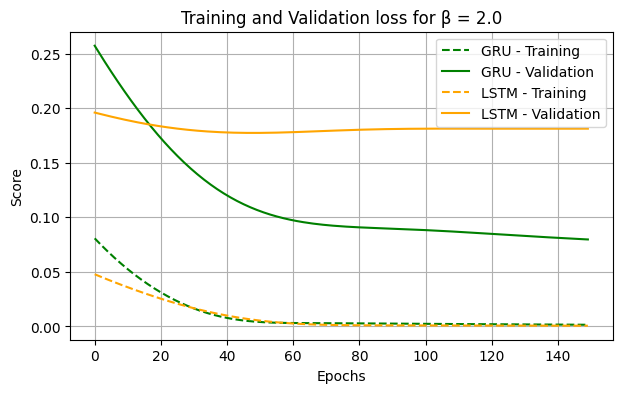

In [34]:
#Plot the Training and Validation loss
plt.figure(figsize=(7, 4),dpi=100)
plt.plot(epochs_GRU,loss_GRU,      label='GRU - Training',  color='green',linestyle='--')
plt.plot(epochs_GRU,val_loss_GRU,  label='GRU - Validation',color='green',linestyle='-')
plt.plot(epochs_LSTM,loss_LSTM,    label='LSTM - Training',  color='orange',linestyle='--')
plt.plot(epochs_LSTM,val_loss_LSTM,label='LSTM - Validation',color='orange',linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Score')
# Ploting the max value of vall_loss. We dont need these all the time, only whem test limits of the network
#plt.scatter(history.history['val_loss'].index(min(history.history['val_loss'])),min(history.history['val_loss']),label=('Min Loss ='+str(round(min(history.history['val_loss']),3))+"\nEpoch = "+str(history.history['val_loss'].index(min(history.history['val_loss'])))),color='purple',zorder=3,marker='*',linewidths=2)
#plt.scatter(history.history['loss'].index(min(history.history['loss'])),min(history.history['loss']),label=('Max Val Loss ='+str(round(min(history.history['loss']),3))+"\nEpoch = "+str(history.history['loss'].index(max(history.history['loss'])))),color='purple',zorder=3,marker='*',linewidths=2)
plt.legend()
plt.title(f"Training and Validation loss for β = {beta}")
#time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_") # What time is that?
time = "_"
plt.savefig(beta+time+"Trai_Val_LOSS.png")                             #Saving the figure with the currently data and time
plt.grid()
plt.show()

In [35]:
# make predictions
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
# trainY1      =([trainY])
# testY1       =([testY])

# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY1[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY1[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
model_data =  numpy.empty_like(dataset) #creating a empyt vector
model_data[look_back:len(trainPredict)+look_back, :] = trainPredict #alocating the the traint data generatead by the model
model_data[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict #alocating the the test data generatead by the model
model_data = (np.reshape(model_data,(len(model_data))))
model_data[:look_back] = numpy.nan
#model_data = model_data[look_back:]

# Killing divergences
for i in range(len(model_data)):
    if model_data[i] > 1: model_data[i] = numpy.nan
    #if model_data[i] < 0.0001: model_data[i] = 0


310/310 [==============================] - 0s 1ms/step


In [36]:
type(beta)

str

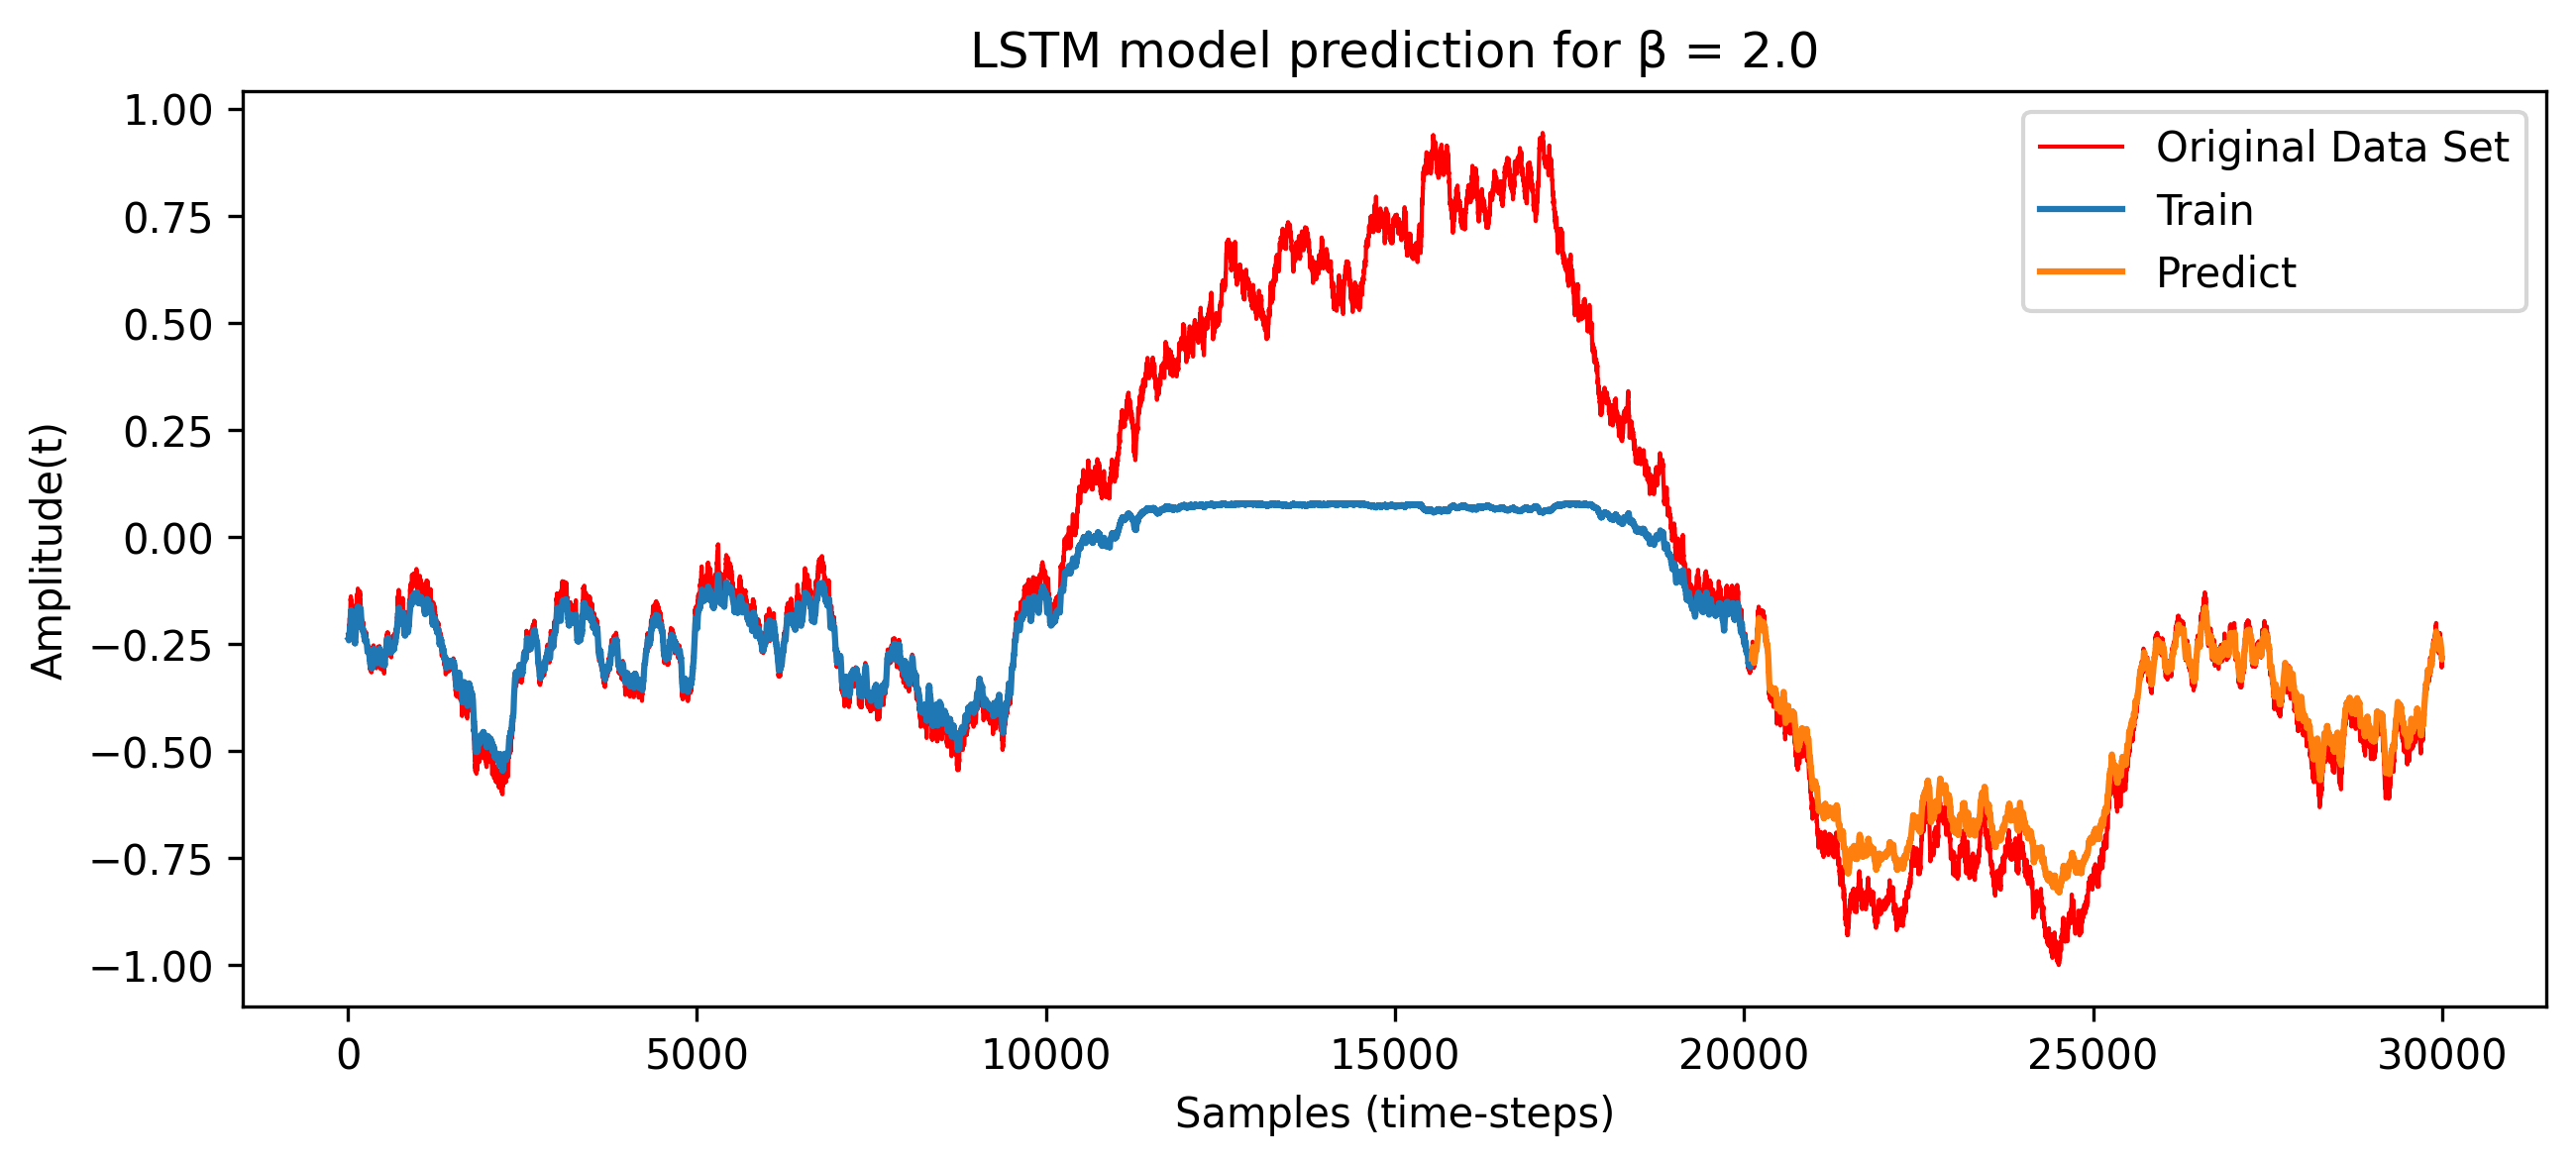

In [37]:
if   beta == '0.0': df_color = 'black'
elif beta == '1.0': df_color = 'magenta'
else              : df_color = 'red'

grossura = 0.5 if beta == '0.0' else 1

time = "EOSBF_"
plt.figure(figsize = (10,4), dpi=300)
plt.plot(dataset,label="Original Data Set",color = df_color,linewidth=grossura)
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Predict')
plt.title(str(modelo_nome)+' model prediction for β = '+str(beta))
#plt.plot(model_data,linestyle='--',linewidth=0.4)
#plt.plot(x,df['Series'][serie_index][max_size:max_size+len(x)])
plt.ylabel('Amplitude(t)')
plt.xlabel('Samples (time-steps)')
plt.legend()
#plt.savefig(time+'Results_beta_'+beta+'model_'+modelo_nome+'lookback_'+str(look_back)+'npoins_'+str(max_size+min_size)+".png")
plt.savefig(beta+'_'+modelo_nome+'Model_Pred.png')
plt.show()

In [38]:
#Alocating these results in a dataframe
df_time =  pd.DataFrame(dataset[:2**int(np.log2(len(dataset)))])
df_model = pd.DataFrame(model_data[:2**int(np.log2(len(model_data)))])

#Creating and save has a CSV
df_time.to_csv("time.csv", index=False, header=False)
df_model.to_csv("model.csv", index=False, header=False)

#Generate
time_series = list(np.reshape(dataset,(1,len(dataset)))[0])
data_model = list(model_data)
df_final = pd.DataFrame({"time_series":time_series,"model_data":data_model})

modelos = 'LSTM' if str(modelo)[-6:-2] else 'GRU'
#time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_")
time = "EOSBF_"
df_final.to_csv(time+'beta_'+beta+'model_'+modelos+'lookback_'+str(look_back)+'npoins_'+str(max_size+min_size)+".csv")

#csv_para_txt
import csv
with open("serie_time.txt", "w") as my_output_file:
    with open("time.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

with open("model_data.txt", "w") as my_output_file:
    with open("model.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()
#

In [28]:
############################################################################
# #The following lines its a code provid by Reinaldo Rosa called SpecPlus.
# #the original code is on google colab. Here, is just a resume
############################################################################



def specplus(nomeArquivo):
    cor = 'black' if nomeArquivo == 'serie_time.txt' else 'C0'

    titulo =  'Original Time Series Data' if nomeArquivo == 'serie_time.txt'  else 'Model Time Series Data'


    import matplotlib.pyplot as plt
    import matplotlib.mlab as mlab
    from scipy import stats, optimize
    import numpy as np
    import math
    __authors__ = 'Paulo Giovani & Reinaldo Rosa'
    __copyright__ = 'Copyright 2017, 3DBMO Project INPE'
    __credits__ = ['Paulo Giovani', 'Reinaldo Roberto Rosa', 'Murilo da Silva Dantas']
    __license__ = 'GPL'
    __version__ = '0.1B'
    __maintainer__ = 'Paulo Giovani'
    __email__ = 'pg_faria@yahoo.com.br'
    time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_")
    #---------------------------------------------------------------------
    # Calcula o PSD da série temporal
    #---------------------------------------------------------------------
    def psd(data):
        """Calcula o PSD de uma série temporal."""
        # Define um intervalo para realizar o ajuste da reta
        INICIO = 15
        FIM = 6300
        # O vetor com o tempo é o tamanho do número de pontos
        N = len(data)
        tempo = np.arange(len(data))
        # Define a frequência de amostragem
        dt = (tempo[-1] - tempo[0] / (N - 1))
        fs = 1 / dt
        # Calcula o PSD utilizando o MLAB
        power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)
        # Calcula a porcentagem de pontos utilizados na reta de ajuste
        totalFrequencias = len(freqs)
        totalPSD = FIM - INICIO
        porcentagemPSD = int(100 * totalPSD / totalFrequencias)
        # Seleciona os dados dentro do intervalo de seleção
        xdata = freqs[INICIO:FIM]
        ydata = power[INICIO:FIM]
        # Simula o erro
        yerr = 0.2 * ydata
        # Define uma função para calcular a Lei de Potência
        powerlaw = lambda x, amp, index: amp * (x**index)
        # Converte os dados para o formato LOG
        logx = np.log10(xdata)
        logy = np.log10(ydata)
        # Define a função para realizar o ajuste
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
        logyerr = yerr / ydata
        # Calcula a reta de ajuste
        pinit = [1.0, -1.0]
        out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)
        pfinal = out[0]
        covar = out[1]
        index = pfinal[1]
        amp = 10.0 ** pfinal[0]
        indexErr = np.sqrt(covar[0][0])
        ampErr = np.sqrt(covar[1][1]) * amp
        # Retorna os valores obtidos
        return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM

    #---------------------------------------------------------------------
    # Calcula o DFA 1D da série temporal
    #---------------------------------------------------------------------

    def dfa1d(timeSeries, grau):
        """Calcula o DFA 1D (adaptado de Physionet), onde a escala cresce
        de acordo com a variável 'Boxratio'. Retorna o array 'vetoutput',
        onde a primeira coluna é o log da escala S e a segunda coluna é o
        log da função de flutuação."""
        # 1. A série temporal {Xk} com k = 1, ..., N é integrada na chamada função perfil Y(k)
        x = np.mean(timeSeries)
        timeSeries = timeSeries - x
        yk = np.cumsum(timeSeries)
        tam = len(timeSeries)
        # 2. A série (ou perfil) Y(k) é dividida em N intervalos não sobrepostos de tamanho S
        sf = np.ceil(tam / 4).astype(np.int)
        boxratio = np.power(2.0, 1.0 / 8.0)
        vetoutput = np.zeros(shape = (1,2))
        s = 4
        while s <= sf:
            serie = yk
            if np.mod(tam, s) != 0:
                l = s * int(np.trunc(tam/s))
                serie = yk[0:l]
            t = np.arange(s, len(serie), s)
            v = np.array(np.array_split(serie, t))
            l = len(v)
            x = np.arange(1, s + 1)
            # 3. Calcula-se a variância para cada segmento v = 1,…, n_s:
            p = np.polynomial.polynomial.polyfit(x, v.T, grau)
            yfit = np.polynomial.polynomial.polyval(x, p)
            vetvar = np.var(v - yfit)
    # 4. Calcula-se a função de flutuação DFA como a média das variâncias de cada intervalo
            fs = np.sqrt(np.mean(vetvar))
            vetoutput = np.vstack((vetoutput,[s, fs]))
            # A escala S cresce numa série geométrica
            s = np.ceil(s * boxratio).astype(np.int)
        # Array com o log da escala S e o log da função de flutuação
        vetoutput = np.log10(vetoutput[1::1,:])
        # Separa as colunas do vetor 'vetoutput'
        x = vetoutput[:,0]
        y = vetoutput[:,1]
        # Regressão linear
        slope, intercept, _, _, _ = stats.linregress(x, y)
        # Calcula a reta de inclinação
        predict_y = intercept + slope * x
        # Calcula o erro
        pred_error = y - predict_y
        # Retorna o valor do ALFA, o vetor 'vetoutput', os vetores X e Y,
        # o vetor com os valores da reta de inclinação e o vetor de erros
        return slope, vetoutput, x, y, predict_y, pred_error
    #---------------------------------------------------------------------
    # Trecho principal
    #---------------------------------------------------------------------
    def main():
        """Função com o código principal do programa."""
        #print("\nSpectral Analysis for time series...\n")
        # Desabilita as mensagens de erro do Numpy (warnings)
        old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
        # Carrega o arquivo de dados
        #nomeArquivo = 'serie1.txt'
        data = np.genfromtxt(nomeArquivo,
                             delimiter = ',',
                             dtype = 'float32',
                             filling_values = 0)
        # Exibe os primeiro N valores do arquivo
        N = 10
        #print("Original time series data (%d points): \n" %(len(data)))
        #print("First %d points: %s\n" %(N, data[0:10]))
        #print()
        #-----------------------------------------------------------------
        # Parâmetros gerais de plotagem
        #-----------------------------------------------------------------
        # Define os subplots
        fig = plt.figure(figsize=(6,4), dpi=100)
        fig.subplots_adjust(hspace = .4, wspace = .2)
        # Tamanho das fontes
        tamanhoFonteEixoX     = 16
        tamanhoFonteEixoY     = 20
        tamanhoFonteTitulo    = 16
        tamanhoFontePrincipal = 25
        # Título principal
        tituloPrincipal = 'Time Series Spectral Analysis'
        #-----------------------------------------------------------------
        # Plotagem da série original
        #-----------------------------------------------------------------
        # Define as cores da plotagem
        corSerieOriginal = cor# 'r'
        # Título dos eixos da série original
        textoEixoX = 'Time'
        textoEixoY = 'Amplitude'
        textoTituloOriginal = titulo
        #print("1. Plotting time series data...")
        # Plotagem da série de dados
        #O = fig.add_subplot(1, 3, 1)
        # O = fig.add_subplot(2, 1, 1)
        # O.plot(data, '-', color = corSerieOriginal)
        # O.set_title(textoTituloOriginal, fontsize = tamanhoFonteTitulo)
        # O.set_xlabel(textoEixoX, fontsize = tamanhoFonteEixoX)
        # O.set_ylabel(textoEixoY, fontsize = tamanhoFonteEixoY)
        # O.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
        # O.grid()
        #-----------------------------------------------------------------
        # Cálculo e plotagem do PSD                                     --
        #-----------------------------------------------------------------
        # Calcula o PSD
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)
        # O valor do beta equivale ao index
        b = index
        # Define as cores da plotagem
        corPSD1 = 'k'
        #corPSD2 =  'orange' if modelo_nome == 'GRU' else 'green'
        corPSD2 =  'navy' if nomeArquivo == 'serie_time.txt' else 'orange' if modelo_nome == 'GRU' else 'green'
        # Título dos eixos do PSD
        textoPSDX = 'Frequency (Hz)'
        textoPSDY = 'PSD'
        #textoTituloPSD = r''+str(modelo_nome)+' - PSD Estimation β = '
        textoTituloPSD = r'Original Time Series - PSD Estimation β = ' if nomeArquivo == 'serie_time.txt' else r'GRU - PSD Estimation β = ' if modelo_nome == 'GRU' else r'LSTM - PSD Estimation β = '
        #print("2. Plotting Power Spectrum Density...")
        # Plotagem do PSD
        PSD = fig.add_subplot(2, 2, (1,4))
        PSD.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
        PSD.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
        PSD.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
        PSD.axvline(freqs[FIM], color = corPSD2, linestyle = '--')
        PSD.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))
        PSD.set_xlabel(textoPSDX                                  )#, fontsize = tamanhoFonteEixoX)
        PSD.set_ylabel(textoPSDY                                  )#, fontsize = tamanhoFonteEixoY)
        PSD.set_title(textoTituloPSD + '%.4f' %(b), loc = 'center')#, fontsize = tamanhoFonteTitulo)
        PSD.set_yscale('log')
        PSD.set_xscale('log')
        PSD.grid()
        #-----------------------------------------------------------------
        # Cálculo e plotagem do DFA
        #-----------------------------------------------------------------
        # Calcula o DFA 1D
        alfa, vetoutput, x, y, reta, erro = dfa1d(data, 1)
        # Verifica se o DFA possui um valor válido
        # Em caso afirmativo, faz a plotagem
        # if not math.isnan(alfa):
        # 	# Define as cores da plotagem
        # 	corDFA = 'darkmagenta'
        # 	# Título dos eixos do DFA
        # 	textoDFAX = '$log_{10}$ (s)'
        # 	textoDFAY = '$log_{10}$ F(s)'
        # 	textoTituloDFA = r'Detrended Fluctuation Analysis $\alpha$ = '
        # 	print("3. Plotting Detrended Fluctuation Analysis...")
        # 	# Plotagem do DFA
        # 	DFA = fig.add_subplot(2, 2, 4)
        # 	DFA.plot(x, y, 's',
        # 			 color = corDFA,
        # 			 markersize = 4
        # 			 markeredgecolor = 'r',
        # 			 markerfacecolor = 'None',
        # 			 alpha = 0.8)
        # 	DFA.plot(x, reta, '-', color = corDFA, linewidth = 1.5)
        # 	DFA.set_title(textoTituloDFA + '%.4f' %(alfa), loc = 'center', fontsize = tamanhoFonteTitulo)
        # 	DFA.set_xlabel(textoDFAX, fontsize = tamanhoFonteEixoX)
        # 	DFA.set_ylabel(textoDFAY, fontsize = tamanhoFonteEixoY)
        # 	DFA.grid()
        # else:
        # 	DFA = fig.add_subplot(2, 2, 4)
        # 	DFA.set_title(textoTituloDFA + 'N.A.', loc = 'center', fontsize = tamanhoFonteTitulo)
        # 	DFA.grid()
        #-----------------------------------------------------------------
        # Exibe e salva a figura
        #-----------------------------------------------------------------
        #plt.suptitle(tituloPrincipal, fontsize = tamanhoFontePrincipal)
        time = "EOSBF_"
        #nomeImagem = beta+modelo_nome+time+nomeArquivo+'ANALYSIS_PSD_DFA_.png'
        nomeImagem = beta+'_'+modelo_nome+nomeArquivo+'_PSD.png'
        fig.set_size_inches(7, 4)
        plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)
        plt.show()
    #---------------------------------------------------------------------
    # Trecho principal
    #---------------------------------------------------------------------
    if __name__ == "__main__":
        main()
    #——————————————————————————————————————————

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

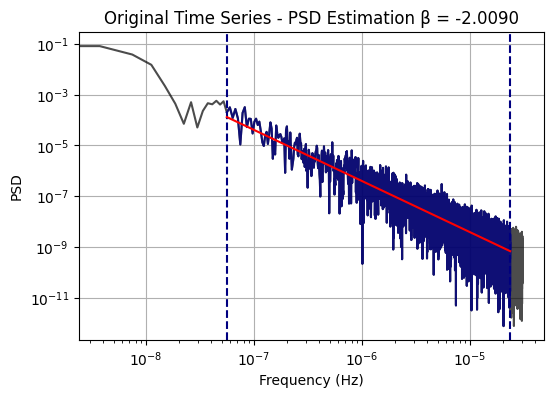

In [29]:
print(specplus('serie_time.txt'))
print(specplus('model_data.txt'))

In [ ]:
#remove all
#!rm *

In [ ]:
#Ziping Data for download📦
#!zip -r /content/All_Files.zip /content